# 4. Querying

#### Imports and constants

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors as pltc
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Geometry libraries
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import psycopg2

from sqlalchemy import create_engine

ROOT = Path.cwd()

In [2]:
DataDir = ROOT / "Data"

### 4a Compare trajectories
a. Compare the trajectories of fishing and ais data sets (before any preprocessing) and comment on their difference.

In [10]:
aisDF = pd.read_csv(DataDir / "ais.csv")
fishingDF = gpd.read_file(DataDir / "geoFishing.shp")

In [116]:
aisDF = aisDF.sort_values(by=["BoatID", "Date"]).reset_index(drop=True)
aisDF

,BoatName,BoatID,Date,Speed,Course,Latitude,Longitude,geometry
0,Mason,111,2020-01-01 08:38:00,"0,1",N,-38.035000,-57.527770,POINT (-38.035 -57.528)
1,Mason,111,2020-01-01 12:27:00,"0,1",SE,-38.035270,-57.527770,POINT (-38.035 -57.528)
2,Mason,111,2020-01-02 08:38:00,"0,1",N,-38.035000,-57.527770,POINT (-38.035 -57.528)
3,Mason,111,2020-01-02 12:27:00,"0,2",SE,-38.035000,-57.527770,POINT (-38.035 -57.528)
4,Mason,111,2020-01-02 23:12:00,"0,2",E,-38.035000,-57.527770,POINT (-38.035 -57.528)
...,...,...,...,...,...,...,...,...
81902,Rodney,115,2020-06-12 22:53:00,0,N,-38.045158,-57.539600,POINT (-38.045 -57.540)
81903,Rodney,115,2020-06-12 23:08:00,0,N,-38.045181,-57.539612,POINT (-38.045 -57.540)
81904,Rodney,115,2020-06-12 23:23:00,0,N,-38.045181,-57.539612,POINT (-38.045 -57.540)
81905,Rodney,115,2020-06-12 23:38:00,0,N,-38.045200,-57.539612,POINT (-38.045 -57.540)


In [117]:
geoAisDF = gpd.GeoDataFrame(aisDF, 
                        geometry=gpd.points_from_xy(aisDF.Latitude, aisDF.Longitude),
                        crs = "EPSG:3857")

In [118]:
geoAisDF

,BoatName,BoatID,Date,Speed,Course,Latitude,Longitude,geometry
0,Mason,111,2020-01-01 08:38:00,"0,1",N,-38.035000,-57.527770,POINT (-38.035 -57.528)
1,Mason,111,2020-01-01 12:27:00,"0,1",SE,-38.035270,-57.527770,POINT (-38.035 -57.528)
2,Mason,111,2020-01-02 08:38:00,"0,1",N,-38.035000,-57.527770,POINT (-38.035 -57.528)
3,Mason,111,2020-01-02 12:27:00,"0,2",SE,-38.035000,-57.527770,POINT (-38.035 -57.528)
4,Mason,111,2020-01-02 23:12:00,"0,2",E,-38.035000,-57.527770,POINT (-38.035 -57.528)
...,...,...,...,...,...,...,...,...
81902,Rodney,115,2020-06-12 22:53:00,0,N,-38.045158,-57.539600,POINT (-38.045 -57.540)
81903,Rodney,115,2020-06-12 23:08:00,0,N,-38.045181,-57.539612,POINT (-38.045 -57.540)
81904,Rodney,115,2020-06-12 23:23:00,0,N,-38.045181,-57.539612,POINT (-38.045 -57.540)
81905,Rodney,115,2020-06-12 23:38:00,0,N,-38.045200,-57.539612,POINT (-38.045 -57.540)


In [119]:
fishingDF

,BoatName,BoatID,Trip,Day,Kg,Duration,Lines,Temperatur,Latitude,Longitude,geometry
0,Mason,111,2020-1,2020-01-12,11492,12,60,14.5,-45.100000,-62.000000,POINT (-45.100 -62.000)
1,Mason,111,2020-1,2020-01-13,10582,12,60,14.5,-45.033333,-62.100000,POINT (-45.033 -62.100)
2,Mason,111,2020-1,2020-01-18,21164,12,60,13.5,-44.833333,-63.816667,POINT (-44.833 -63.817)
3,Mason,111,2020-1,2020-01-19,18980,12,60,14.0,-44.833333,-63.833333,POINT (-44.833 -63.833)
4,Mason,111,2020-1,2020-01-20,16796,12,60,13.7,-44.866667,-63.816667,POINT (-44.867 -63.817)
...,...,...,...,...,...,...,...,...,...,...,...
639,Rodney,115,2020-5,2020-06-21,21790,12,100,11.0,-42.016667,-59.466667,POINT (-42.017 -59.467)
640,Rodney,115,2020-5,2020-06-22,20410,12,100,11.2,-42.050000,-59.450000,POINT (-42.050 -59.450)
641,Rodney,115,2020-5,2020-06-25,23330,12,100,10.3,-42.083333,-59.416667,POINT (-42.083 -59.417)
642,Rodney,115,2020-5,2020-06-26,8120,12,100,10.9,-41.916667,-59.433333,POINT (-41.917 -59.433)


## GEOAIS

In [120]:
geoAisMP = geoAisDF.dissolve(["BoatName", "BoatID"], aggfunc='mean')
geoAisMP  = geoAisMP.reset_index()
geoAisMP  = geoAisMP.iloc[:, 0:3].sort_values("BoatID").reset_index(drop="True")
geoAisMP 

,BoatName,BoatID,geometry
0,Mason,111,"MULTIPOINT (-48.340 -60.864, -48.338 -60.857, ..."
1,Rey,112,"MULTIPOINT (-48.320 -60.794, -48.319 -60.796, ..."
2,Korbin,113,"MULTIPOINT (-48.319 -60.814, -48.316 -60.811, ..."
3,Armani,114,"MULTIPOINT (-48.114 -61.086, -48.114 -61.086, ..."
4,Rodney,115,"MULTIPOINT (-48.497 -61.355, -48.483 -61.323, ..."


In [121]:
lines = []
for i, _ in geoAisMP.iterrows():

    lines.append(LineString([x for x in geoAisMP['geometry'][i].geoms]))

    
geoAisMP["geomLS"] = lines

geoAisTraj = geoAisMP.copy()
geoAisTraj.set_geometry(geoAisTraj['geomLS'], inplace=True)
geoAisTraj = geoAisTraj.drop(columns=["geomLS"])
geoAisTraj

c:\Users\enriq\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,BoatName,BoatID,geometry
0,Mason,111,"LINESTRING (-48.340 -60.864, -48.338 -60.857, ..."
1,Rey,112,"LINESTRING (-48.320 -60.794, -48.319 -60.796, ..."
2,Korbin,113,"LINESTRING (-48.319 -60.814, -48.316 -60.811, ..."
3,Armani,114,"LINESTRING (-48.114 -61.086, -48.114 -61.086, ..."
4,Rodney,115,"LINESTRING (-48.497 -61.355, -48.483 -61.323, ..."


## GEOFISHING

In [122]:
geoFishingDF = gpd.GeoDataFrame(fishingDF, 
                                geometry=gpd.points_from_xy(fishingDF.Latitude, fishingDF.Longitude),
                                crs = "EPSG:3857")

In [126]:
geoFishingDF

,BoatName,BoatID,Trip,Day,Kg,Duration,Lines,Temperatur,Latitude,Longitude,geometry
0,Mason,111,2020-1,2020-01-12,11492,12,60,14.5,-45.100000,-62.000000,POINT (-45.100 -62.000)
1,Mason,111,2020-1,2020-01-13,10582,12,60,14.5,-45.033333,-62.100000,POINT (-45.033 -62.100)
2,Mason,111,2020-1,2020-01-18,21164,12,60,13.5,-44.833333,-63.816667,POINT (-44.833 -63.817)
3,Mason,111,2020-1,2020-01-19,18980,12,60,14.0,-44.833333,-63.833333,POINT (-44.833 -63.833)
4,Mason,111,2020-1,2020-01-20,16796,12,60,13.7,-44.866667,-63.816667,POINT (-44.867 -63.817)
...,...,...,...,...,...,...,...,...,...,...,...
639,Rodney,115,2020-5,2020-06-21,21790,12,100,11.0,-42.016667,-59.466667,POINT (-42.017 -59.467)
640,Rodney,115,2020-5,2020-06-22,20410,12,100,11.2,-42.050000,-59.450000,POINT (-42.050 -59.450)
641,Rodney,115,2020-5,2020-06-25,23330,12,100,10.3,-42.083333,-59.416667,POINT (-42.083 -59.417)
642,Rodney,115,2020-5,2020-06-26,8120,12,100,10.9,-41.916667,-59.433333,POINT (-41.917 -59.433)


In [127]:
geoFishingMP = geoFishingDF.dissolve(["BoatName", "BoatID"], aggfunc='mean')
geoFishingMP = geoFishingMP.reset_index()
geoFishingMP = geoFishingMP.iloc[:, 0:3].sort_values("BoatID").reset_index(drop="True")
geoFishingMP

,BoatName,BoatID,geometry
0,Mason,111,"MULTIPOINT (-48.317 -60.850, -48.300 -63.017, ..."
1,Rey,112,"MULTIPOINT (-48.200 -60.800, -48.017 -60.933, ..."
2,Korbin,113,"MULTIPOINT (-48.217 -60.867, -48.200 -60.800, ..."
3,Armani,114,"MULTIPOINT (-48.450 -60.817, -48.067 -61.100, ..."
4,Rodney,115,"MULTIPOINT (-48.417 -61.267, -48.350 -61.267, ..."


In [128]:
lines = []
for i, _ in geoFishingMP.iterrows():

    lines.append(LineString([x for x in geoFishingMP['geometry'][i].geoms]))

    
geoFishingMP["geomLS"] = lines

geoFishingTraj = geoFishingMP.copy()
geoFishingTraj.set_geometry(geoFishingTraj['geomLS'], inplace=True)
geoFishingTraj = geoFishingTraj.drop(columns=["geomLS"])
geoFishingTraj


c:\Users\enriq\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,BoatName,BoatID,geometry
0,Mason,111,"LINESTRING (-48.317 -60.850, -48.300 -63.017, ..."
1,Rey,112,"LINESTRING (-48.200 -60.800, -48.017 -60.933, ..."
2,Korbin,113,"LINESTRING (-48.217 -60.867, -48.200 -60.800, ..."
3,Armani,114,"LINESTRING (-48.450 -60.817, -48.067 -61.100, ..."
4,Rodney,115,"LINESTRING (-48.417 -61.267, -48.350 -61.267, ..."


### Compare linestring by IDs

In [112]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white", "black"])

<AxesSubplot:>

<Figure size 1440x1280 with 0 Axes>

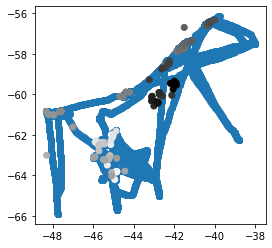

In [132]:
plt.figure(figsize=(18,16), dpi=80)

base = geoAisDF[geoAisDF["BoatID"] == 111].plot()
geoFishingDF[geoFishingDF["BoatID"] == 111].plot(column='Day', ax=base, cmap=cmap)

<AxesSubplot:>

<Figure size 1440x1280 with 0 Axes>

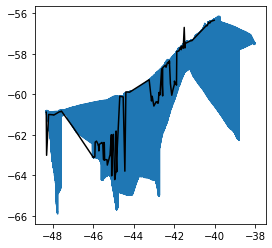

In [130]:
plt.figure(figsize=(18,16), dpi=80)

base = geoAisTraj[geoAisTraj["BoatID"] == 111].plot()
geoFishingTraj[geoFishingTraj["BoatID"] == 111].plot(ax=base, cmap='copper')


We can realize that the line from the fishing dataset (1 coordinate per day) not represents the complete path that the boat does throughout the day. In fact, the first fishing dataset has gaps of several days and we don't know what course each ship had during this space of time. If we look the second dataset we can check what was the true trajectory it took.

In [95]:
geoFishingTraj.geometry.length

0    57.141749
1    52.575308
2    60.749878
3    44.883094
4    60.462035
dtype: float64

In [94]:
geoAisTraj.geometry.length

0    8567.280539
1    6195.774265
2    5263.285788
3    7784.049830
4    4998.809720
dtype: float64

In [98]:
len(geoFishingTraj.geometry[0].coords)

111

In [99]:
len(geoAisTraj.geometry[0].coords)

11639

In [139]:
print(geoFishingTraj.geometry[0].representative_point())
print(geoAisTraj.geometry[0].representative_point())
print((geoFishingTraj.geometry[0].representative_point()).distance(geoAisTraj.geometry[0].representative_point()))

POINT (-44.866666666666696 -61.8166666666667)
POINT (-42.69666 -61.35305)
2.2189793480312145


In [142]:
geoFishingTraj.geometry[0].equals(geoAisTraj.geometry[0])

False

We can realize that the number of coordinates and the length of every trajectory is shorter in the fishing dataset, this is related with the previous conclusions. Since it exists several time gap between the sampling the transformation I made to generate the trajectory assumes that the boat goes from one point to another following a straight line, when we already know that this not occurs in reality.

Thanks to the ais dataset we can know the real path every boat did (that is not considered equal to the gived by the fishing dataset). 